In [979]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re

from sklearn.decomposition import PCA, SparsePCA,TruncatedSVD
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score
from pymongo import MongoClient
import re

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


%matplotlib inline

In [988]:
city = 'Seattle'
state = 'WA'
client = MongoClient('localhost', 27017)
db = client['neighborhood_recommender']
collection = db['crime' + '_' + city + '_' + state]
cursor = collection.find()
data = [crime for crime in cursor]
df = pd.DataFrame(data)

In [994]:
cols_to_drop = ['DISORDERLY CONDUCT', 'FRAUD AND FINANCIAL', 'LOITERING', 'LOST PROPERTY', 'OBSTRUCT', 'PICKPOCKET', '[INC - CASE DC USE ONLY]', 'ESCAPE', 'FALSE REPORT', 'FORGERY', 'COUNTERFEIT', 'DISTURBANCE', 'ELUDING', 'EMBEZZLE', 'FRAUD', 'INJURY', 'SHOPLIFTING', 'TRAFFIC', 'VIOLATION OF COURT ORDER', 'THREATS', 'FIREWORK','ANIMAL COMPLAINT', 'DISPUTE', 'ILLEGAL DUMPING','RECKLESS BURNING', 'RECOVERED PROPERTY', 'BIAS INCIDENT', 'GAMBLE']
df = df[df.columns.diff(cols_to_drop)]

In [991]:
df = df.ix[~df['hood'].isnull(), :]


In [992]:
counts = df.groupby(['hood','summarized_offense_description'])['offense_type'].count()
df = pd.DataFrame(counts).reset_index()

In [993]:
df = df.pivot(index = 'hood', values = 'offense_type', columns = 'summarized_offense_description')
names = df.index

In [1007]:
mask = (df.dtypes == np.float64) | (df.dtypes == np.int)
df_sub = df.ix[:, mask]
df_sub = df_sub.dropna(axis = 1, thresh = 60)

df_sub = df_sub.fillna(0)
#a = df_sub.apply(lambda s : s.value_counts().get(0,0), axis=0)
#a = a[a > 50].index

#df_sub = df_sub[a]
#df_sub = df_sub.replace(0, df.median())
#df_sub['total'] = df_sub.sum(axis = 1)

In [1008]:
svd = TruncatedSVD(n_components=3)
X_svd = svd.fit_transform(X_centered)
print svd.explained_variance_ratio_

[ 0.41831769  0.14627365  0.09983897]


In [1012]:
pca = PCA(n_components = 3)
imp = preprocessing.Imputer(axis=0)
X = imp.fit_transform(df_new)
X_centered = preprocessing.scale(X)
X_pca = pca.fit_transform(X_centered)
print(pca.explained_variance_ratio_)

[ 0.66078929  0.20738056  0.11283099]


In [985]:
df_c = pd.DataFrame(svd.components_.T, index = df_new.columns, columns = [1,2,3])

In [986]:
df_c.sort(3, ascending = True)

,1,2,3
[u'METRO'],0.209361,0.514647,-0.287592
[u'HARBOR CALLs'],0.007762,0.136637,-0.279758
"[u'BURGLARY-SECURE PARKING-RES', u'DUI']",0.326649,0.412368,-0.244887
"[u'LIQUOR VIOLATION', u'PUBLIC NUISANCE']",0.339701,-0.266672,-0.144492
"[u'ASSAULT', u'PURSE SNATCH', u'ROBBERY', u'STOLEN PROPERTY', u'THEFT OF SERVICES', u'TRESPASS', u'WEAPON']",0.423264,-0.144474,-0.088736
"[u'NARCOTICS', u'STAY OUT OF AREA OF DRUGS', u'WARRANT ARREST']",0.354899,-0.370710,-0.088426
"[u'BIKE THEFT', u'BURGLARY', u'CAR PROWL', u'OTHER PROPERTY', u'PROPERTY DAMAGE', u'VEHICLE THEFT']",0.418726,0.131335,0.040246
[u'PORNOGRAPHY'],0.255964,-0.347657,0.091854
[u'EXTORTION'],0.252521,0.015310,0.094677
[u'HOMICIDE'],0.290388,-0.040139,0.198611


In [950]:
clusterer = DBSCAN(eps=1, min_samples=3)
cluster_labels = clusterer.fit_predict(X_pca)
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [889]:
from sklearn.cluster import DBSCAN

In [1013]:
for i in [4,5,6,7,8]:
    clusterer = KMeans(n_clusters=i)
    cluster_labels = clusterer.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)

('For n_clusters =', 4, 'The average silhouette_score is :', 0.542689997565872)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.47663166759985642)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.41961307821913008)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.37613540743824875)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.38442193100273908)


In [1001]:
silhouette_avg

0.41446530051578634

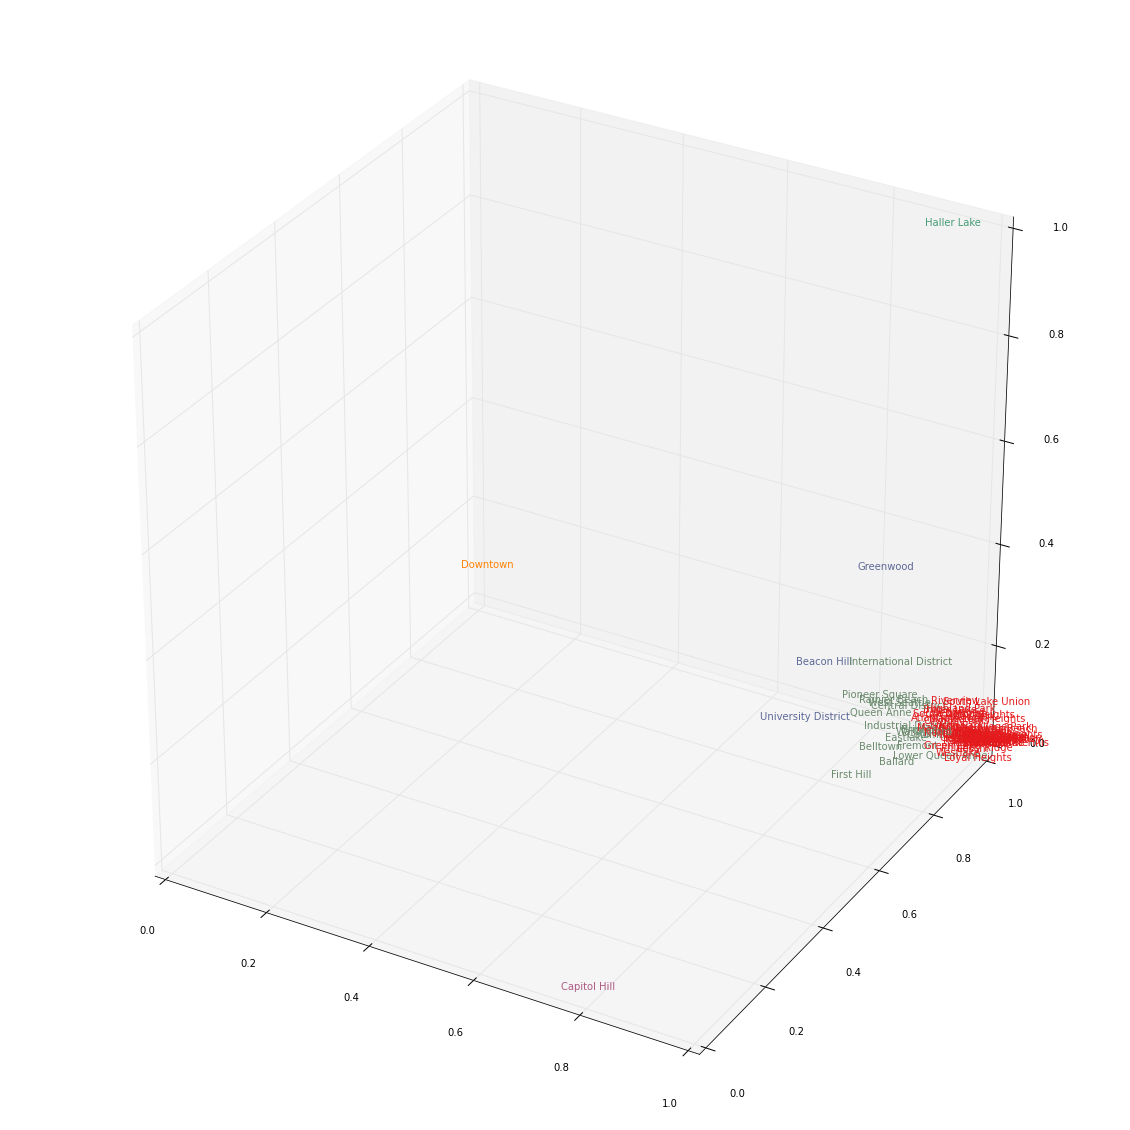

In [963]:
plot_embedding(X_pca, cluster_labels, names)

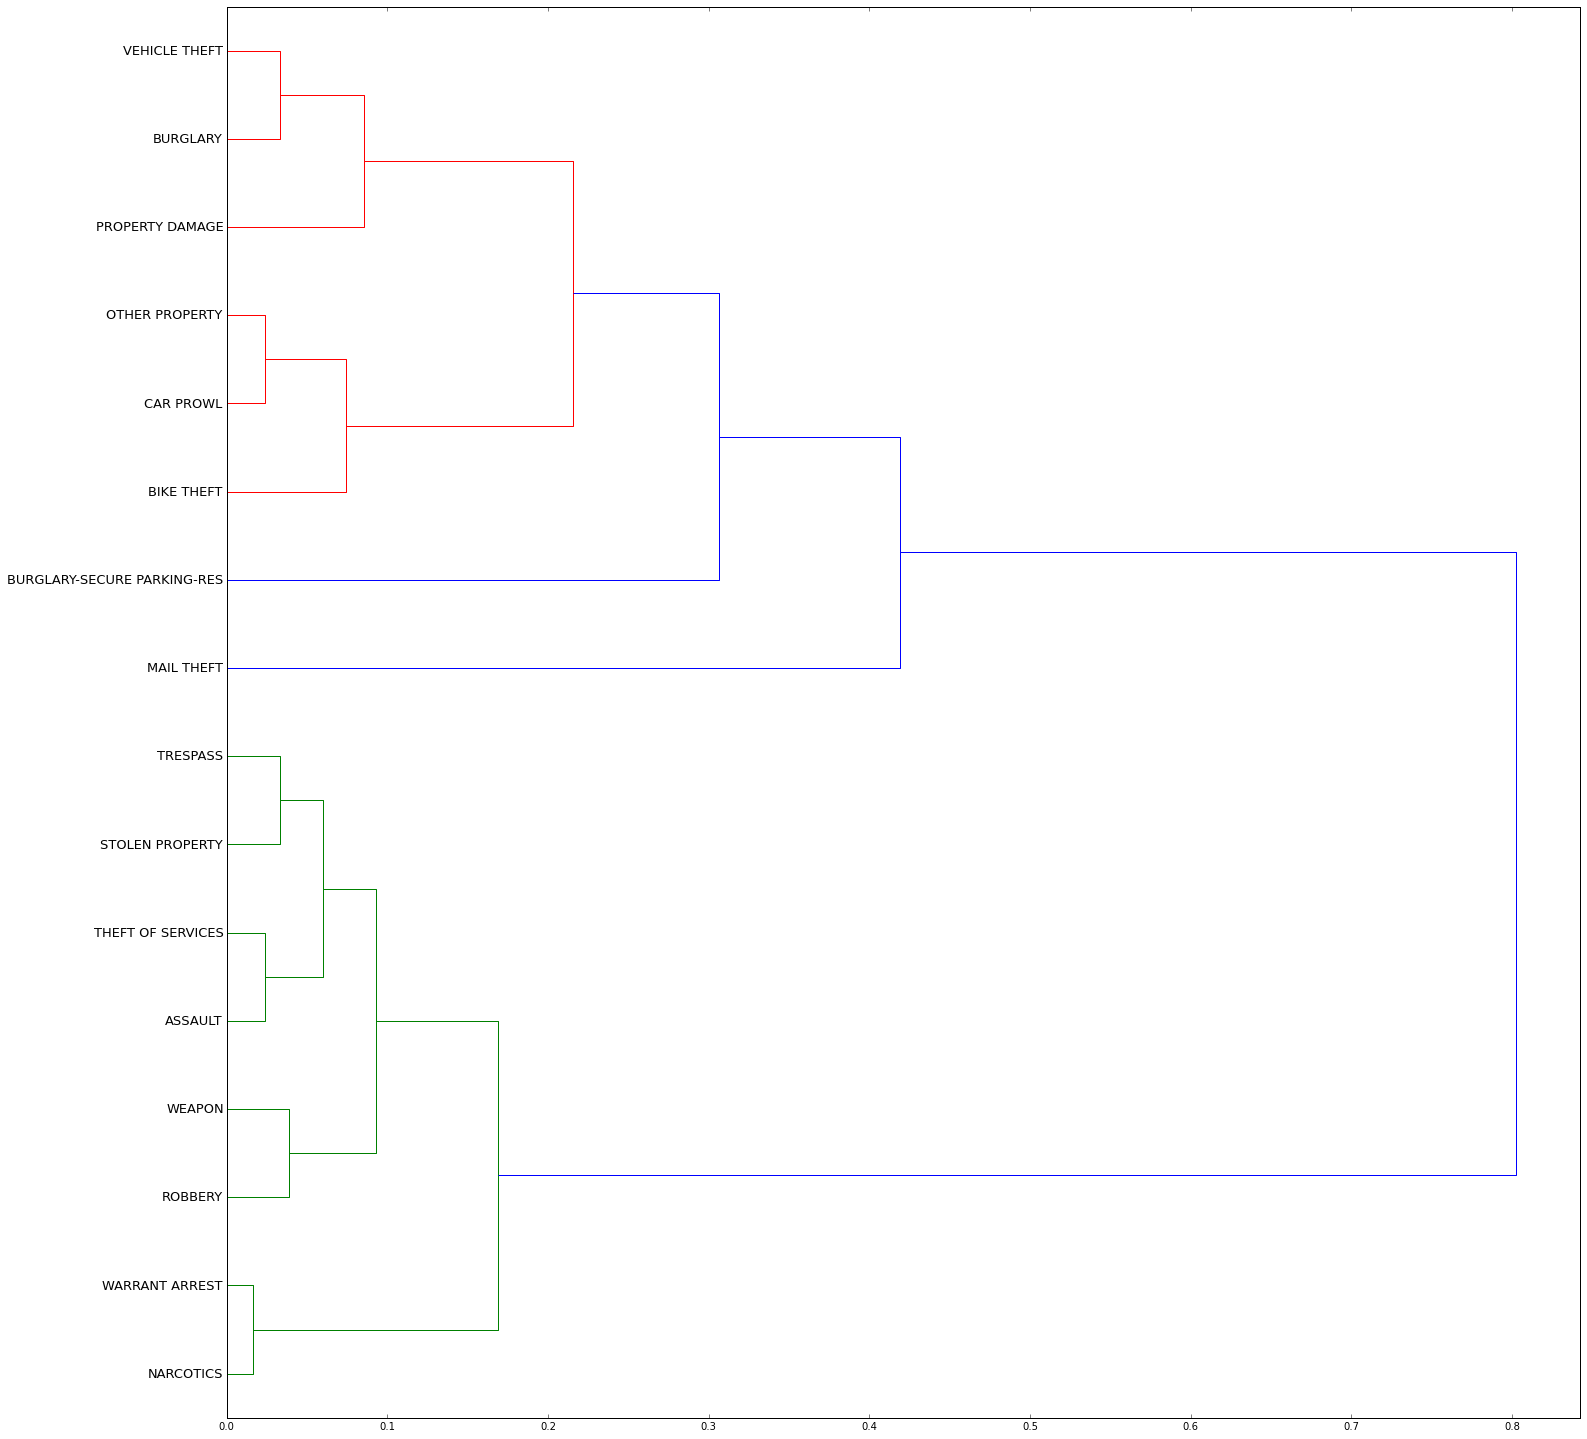

In [1005]:
link = linkage(df_sub.T, method='complete', metric = 'cosine')

# 5. Using scipy's dendrogram function plot the linkages as
# a hierachical tree.
plt.figure(figsize=(20,40))
dendro = dendrogram(link, color_threshold=0.3, leaf_font_size=13, labels = df_sub.columns, orientation = 'left')
plt.subplots_adjust(top=.99, bottom=0.5, left=0.05, right=0.99)
plt.show()

In [921]:
def plot_embedding(X, y, name_list, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(20, 20), dpi=250)
    ax = plt.subplot(111, projection='3d')
    #ax.axis('off')
    #ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],X[i,2], str(name_list[i]), color=plt.cm.Set1(y[i] / 10.), fontsize = 10)


#     ax.set_xlim3d(-1, 1.1)
#     ax.set_ylim3d(-1, 1.1)
#     ax.set_zlim3d(-1, 1.1)
    if title is not None:
        plt.title(title, fontsize=16)

In [875]:
assignments = fcluster(link, .25, 'distance')


In [1011]:
assignments = fcluster(link, .25, 'distance')
d = pd.DataFrame(zip(df_sub.columns,assignments)).groupby(1)[0].aggregate(lambda x: tuple(x))
df_new = pd.DataFrame(index = df_sub.index)
df_sub1 = (df_sub - df_sub.mean()) / (df_sub.max() - df_sub.min())
for i in d:
    ar = []
    for w in i:
        ar.append(w)
    if len(ar) > 1:
        df_new[str(ar)] = df_sub1[ar].sum(axis = 1)
    else:
        ad = df_sub1[ar].values
        df_new[str(ar)] = ad


In [969]:
names[[0,2,3]]

Index([u'Admiral', u'Arbor Heights', u'Atlantic'], dtype='object', name=u'hood')

KeyError: "[(u'NARCOTICS', u'STAY OUT OF AREA OF DRUGS', u'WARRANT ARREST')\n (u'ASSAULT', u'PURSE SNATCH', u'ROBBERY', u'STOLEN PROPERTY', u'THEFT OF SERVICES', u'TRESPASS', u'WEAPON')\n (u'PORNOGRAPHY',) (u'LIQUOR VIOLATION', u'PUBLIC NUISANCE') (u'HOMICIDE',)\n (u'BURGLARY-SECURE PARKING-RES', u'DUI')\n (u'BIKE THEFT', u'BURGLARY', u'CAR PROWL', u'OTHER PROPERTY', u'PROPERTY DAMAGE', u'VEHICLE THEFT')\n (u'MAIL THEFT',) (u'EXTORTION',) (u'METRO',)\n (u'PROSTITUTION', u'STAY OUT OF AREA OF PROSTITUTION') (u'HARBOR CALLs',)] not in index"

In [999]:
names.values

array([u'Admiral', u'Alki', u'Arbor Heights', u'Atlantic', u'Ballard',
       u'Beacon Hill', u'Belltown', u'Bitter Lake', u'Blue Ridge',
       u'Brighton', u'Broadmoor', u'Broadview', u'Bryant', u'Capitol Hill',
       u'Cedar Park', u'Central District', u'Columbia City', u'Crown Hill',
       u'Denny-Blaine', u'Downtown', u'Eastlake', u'Fauntleroy',
       u'First Hill', u'Fremont', u'Georgetown', u'Green Lake',
       u'Greenwood', u'Haller Lake', u'Hawthorne Hills', u'High Point',
       u'Highland Park', u'Industrial District', u'Interbay',
       u'International District', u'Laurelhurst', u'Leschi',
       u'Lower Queen Anne', u'Loyal Heights', u'Madison Park',
       u'Madison Valley', u'Madrona', u'Magnolia', u'Maple Leaf',
       u'Matthews Beach', u'Meadowbrook', u'Montlake', u'Mount Baker',
       u'North Beach', u'North College Park', u'North Delridge',
       u'Northgate', u'Olympic Hills', u'Olympic Manor', u'Phinney Ridge',
       u'Pinehurst', u'Pioneer Square', u'Port

In [1006]:
df_new.columns

Index([u'[u'NARCOTICS', u'STAY OUT OF AREA OF DRUGS', u'WARRANT ARREST']',
       u'[u'ASSAULT', u'PURSE SNATCH', u'ROBBERY', u'STOLEN PROPERTY', u'THEFT OF SERVICES', u'TRESPASS', u'WEAPON']',
       u'[u'PORNOGRAPHY']', u'[u'LIQUOR VIOLATION', u'PUBLIC NUISANCE']',
       u'[u'HOMICIDE']', u'[u'BURGLARY-SECURE PARKING-RES', u'DUI']',
       u'[u'BIKE THEFT', u'BURGLARY', u'CAR PROWL', u'OTHER PROPERTY', u'PROPERTY DAMAGE', u'VEHICLE THEFT']',
       u'[u'MAIL THEFT']', u'[u'EXTORTION']', u'[u'METRO']',
       u'[u'PROSTITUTION', u'STAY OUT OF AREA OF PROSTITUTION']',
       u'[u'HARBOR CALLs']'],
      dtype='object')